##### Importing Packages

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime

##### Loading Data

In [2]:
TASK_PATH = r"C:\Users\jpgsa\Documents\BOLT" + "\\"
file1 = "Dataset Task 1.xlsx"
df1_raw = pd.read_excel(TASK_PATH + file1)

df1_raw.head()

,Time,Category level 0,Category level 1,Category level 2,Unique SKUs Listed,Unique SKUs Sold,# of sold SKU items,Price before Discount (includ. VAT) (EUR),Discount Value (EUR),Item COGS (net VAT) (EUR),"Waste, # of items"
0,2023-09-17,Fresh Food,🧀 Cheese,Hard Cheese,26,17,37,135.812592,10.491467,88.81738,0
1,2023-08-02,Fresh Food,🍞 Bakery,Gluten Free,1,0,0,0.000000,0.000000,0.00000,0
2,2023-08-26,Fresh Food,🥛 Dairy & Eggs,Sour Cream & Cream,14,10,26,53.454514,3.213313,31.87778,0
3,2023-09-24,Fresh Food,🥪 Fresh & Ready,Desserts & Sweets,25,13,47,61.698558,3.516517,41.22566,0
4,2023-09-15,Fresh Food,🍗 Meat & Fish,Meat & Fish Alternatives,17,3,8,13.061563,1.358066,8.68154,0


In [3]:
df1 = df1_raw.copy()
df1["perc_discount"] = df1["Discount Value (EUR)"] / df1["Price before Discount (includ. VAT) (EUR)"]
df1["category_tree"] = df1["Category level 0"] + "/" +  df1["Category level 1"] + "/" + df1["Category level 2"]
df1["avg_item_price"] = df1["Price before Discount (includ. VAT) (EUR)"] / df1["# of sold SKU items"]

##### Analysis Approach:
1. Discount Elasticity
2. Categories Affinity
3. Catalog Size Optimization
4. Estimated Loss per Category
5. Net Revenue and % Margin
6. Time Series Exploration
    1. % Wasted Itens
    2. Revenue, Cost & Discount
    3.  % Discount and % Net Margin

##### 1) Discount Elasticity - Correlation between **qty itens** and **% discount** daily, per item

In [130]:
df_elast1 = df1.groupby('category_tree')[['perc_discount','# of sold SKU items']].corr().iloc[0::2,-1].reset_index().drop("level_1", axis = 1).rename(columns={"# of sold SKU items": "correl_disc_and_qty"})

df_temp = df1[["category_tree", "# of sold SKU items","avg_item_price"]]
df_temp = df_temp.groupby("category_tree").mean()[["# of sold SKU items","avg_item_price"]].reset_index().rename(columns={"# of sold SKU items": "avg_itens_sold_daily"})

df_elast2 = pd.merge(df_elast1, df_temp, left_on='category_tree', right_on='category_tree')
df_elast2.sort_values("correl_disc_and_qty", ascending=False, inplace=True)
df_elast2.reset_index(drop=True, inplace=True)

df_elast2.head(20)

,category_tree,correl_disc_and_qty,avg_itens_sold_daily,avg_item_price
0,Grocery Food/🥤 Beverages/More Beverages,0.935812,0.120879,3.558840
1,Fresh Food/🍗 Meat & Fish/Fresh Meat,0.503441,37.131868,4.476076
2,Fresh Food/🍗 Meat & Fish/Fresh Poultry,0.470720,40.945055,4.326510
3,Fresh Food/🥕 Fruits & Vegetables/Berries,0.454022,48.000000,2.040084
4,Grocery Food/❄️ Frozen Products/Frozen Fruits ...,0.380585,4.923077,5.278142
5,Grocery Food/🧑‍🍳 Pantry/Sugar Free Pantry,0.371779,0.252747,2.827747
6,Grocery Food/🍦 Ice Cream/Large,0.368116,69.670330,8.084641
7,Grocery Food/🥃 Spirits/Liqueurs,0.366234,1.340659,19.181716
8,Grocery Food/❄️ Frozen Products/Frozen Meals,0.341998,19.395604,3.996358
9,Grocery Food/🥃 Spirits/Vodka,0.341005,5.648352,12.427498


* We could experiment campaigns with the items with highest elasticity (based on correlation %disc e qty sold)
* NOTE: Our selection should also be based on items with a minium avg qty, however

##### 2) Categories Affinity - Correlation of itens sold daily, between different itens

In [9]:
df_temp = df1[["Time","category_tree", "# of sold SKU items"]]
df_temp = df_temp[df_temp["category_tree"] != "Other/♻️ Save me!/Packaging fee"] ## discarded for calculating affinity

df_temp_pivot = df_temp.pivot(index='Time', columns='category_tree', values='# of sold SKU items')
corr_matrix  = df_temp_pivot.corr()
corr_matrix.rename(columns={"category_tree": "category_tree_2"})

corr_pairs = corr_matrix.unstack()
corr_pairs.index.names = ["Category A", "Category B"]
corr_pairs = corr_pairs.reset_index()
corr_pairs = corr_pairs.rename(columns={0: "Correl"})
corr_pairs = corr_pairs[corr_pairs["Category A"] != corr_pairs["Category B"]]

corr_pairs['Pair'] = np.where(corr_pairs['Category A'] > corr_pairs['Category B'] 
                              , corr_pairs['Category A'] + " + " + corr_pairs['Category B']
                              , corr_pairs['Category B'] + " + " + corr_pairs['Category A'])

corr_pairs = corr_pairs[["Pair","Correl"]]
corr_pairs.sort_values("Correl", ascending=False, inplace=True)
corr_pairs =corr_pairs.drop_duplicates(subset=["Pair"])
corr_pairs.reset_index(inplace=True, drop=True)


for index, row in corr_pairs.head(20).iterrows():
    print("Correl: ",round(row['Correl'],2), "  Combo: ",row['Pair'].split(" + "))

Correl:  0.61   Combo:  ['Grocery Food/🥤 Beverages/Kombucha', 'Fresh Food/🥕 Fruits & Vegetables/Bio & Organic']
Correl:  0.57   Combo:  ['Fresh Food/🍞 Bakery/Sliced Bread, Wraps & More', 'Fresh Food/🍗 Meat & Fish/Bacon & Cold Cuts']
Correl:  0.57   Combo:  ['Grocery Food/🍷 Wine/White Wine', 'Grocery Food/🍷 Wine/Rose Wine']
Correl:  0.56   Combo:  ['Fresh Food/🥕 Fruits & Vegetables/Vegetables', 'Fresh Food/🥕 Fruits & Vegetables/Salad Mixes']
Correl:  0.56   Combo:  ['Fresh Food/🥛 Dairy & Eggs/Yogurt & Pudding', 'Fresh Food/🍞 Bakery/Sliced Bread, Wraps & More']
Correl:  0.55   Combo:  ['Grocery Food/🍺 Beer & Cider/International Beer', 'Grocery Food/🍷 Wine/White Wine']
Correl:  0.54   Combo:  ['Grocery Food/🍺 Beer & Cider/National Favourites', 'Grocery Food/🍷 Wine/White Wine']
Correl:  0.54   Combo:  ['Grocery Food/🍬 Sweet Snacks/Biscuits', 'Fresh Food/🥪 Fresh & Ready/Desserts & Sweets']
Correl:  0.53   Combo:  ['Grocery Food/🥘 Instant Meals/Instant Pasta & Noodles', 'Grocery Food/🍬 Sweet

* This analysis shows us itens that have a similar daily curve of sales, i.e. tend to have the same sales evolution in time
* It's interesting we see items we would naturally assume are purchased by the same type of use, like: 
    * "Kombucha" + "Bio & Organic Fruits and Veggies"
    * "Slice Bread / Wraps" + "Bacon & Cold Cuts"
    * "White Wine" + "Red Wine"
* This uncovers two possibilities:
    * A future deep-dive on the user's carts could identify specific SKUs that are usually purchased together. We can use this for marketing campaigns to achieve upselling.
    * We can use these category similarities to refine our stock prediction models.

##### 3) Catalog Size Optimization: Size vs. % Sold Daily

In [14]:
df_catalog = df1[["Time","category_tree","Unique SKUs Listed","Unique SKUs Sold"]].copy()
df_catalog["perc_catalog_sold"] = df_catalog["Unique SKUs Sold"] / df_catalog["Unique SKUs Listed"]

df_catalog_grouped = df_catalog[df_catalog.columns[1:]].groupby("category_tree").mean().reset_index()
df_catalog_grouped = df_catalog_grouped.sort_values("perc_catalog_sold", ascending=True)
df_catalog_grouped[df_catalog_grouped["Unique SKUs Listed"] > 20].head(20).reset_index(drop=True)

,category_tree,Unique SKUs Listed,Unique SKUs Sold,perc_catalog_sold
0,Grocery Non-Food/🎲 Toys & Games/Games,34.483516,0.450549,0.013085
1,Grocery Non-Food/🎲 Toys & Games/Toys,68.406593,1.164835,0.017020
2,Grocery Non-Food/🏡 Home Accessories/Stationery,55.274725,1.945055,0.035245
3,Grocery Non-Food/🏡 Home Accessories/Electronics,35.934066,1.835165,0.051029
4,Grocery Food/🍷 Wine/Red Wine,90.164835,7.813187,0.087678
5,Grocery Non-Food/👶 Baby Care/Baby Food,28.241758,2.637363,0.093556
6,Not defined/Not defined/Not defined,33.681319,3.703297,0.109570
7,Grocery Non-Food/🏡 Home Accessories/More Home ...,23.340659,2.923077,0.125159
8,Grocery Non-Food/🩹 Health & Safety/Feel Better,25.000000,3.252747,0.130110
9,"Grocery Food/☕️ Coffee, Tea & Cocoa/Tea",38.395604,5.285714,0.140851


* The table above filters itens that have a daily catalog size of > 20 itens, so we can assume users have a tendency of not scrolling to the entiriy of the catalog.
* In addition, it's ordered by the % of the catalog itens that is actually sold daily (based on unique skus), ascending (LOW -> HIGH).
* We should access these categories and experiment optimizing our items rankings and visual merchandise.
* We can even reduce catalog sizes since they could potentially be lowering the visibility of items that would have a higher conversion.

In [25]:
test_df = df_catalog_grouped[df_catalog_grouped["Unique SKUs Listed"] > 20].head(20)["category_tree"].reset_index(drop=True).copy()
test_df[19]

'Grocery Food/🥫 Canned Goods & Preserves/Canned Vegetable'

##### 4) Estimated Total Loss (based on wasted items and avg COGS)

In [142]:
df_waste = df1[["category_tree","# of sold SKU items","Item COGS (net VAT) (EUR)","Waste, # of items"]]
df_waste_grouped = df_waste.groupby("category_tree").sum().reset_index()

df_waste_grouped["Avg. COGS per Item"] = df_waste_grouped["Item COGS (net VAT) (EUR)"] / df_waste_grouped["# of sold SKU items"]
df_waste_grouped["Est. Total Loss (EUR)"] = df_waste_grouped["Waste, # of items"] * df_waste_grouped["Avg. COGS per Item"]

df_waste_grouped = df_waste_grouped.sort_values("Est. Total Loss (EUR)", ascending=False).reset_index(drop=True)
df_waste_grouped.head(10)

,category_tree,# of sold SKU items,Item COGS (net VAT) (EUR),"Waste, # of items",Avg. COGS per Item,Est. Total Loss (EUR)
0,Fresh Food/🥕 Fruits & Vegetables/Fruits,24094,26588.27060,2779,1.103522,3066.688968
1,Fresh Food/🍗 Meat & Fish/Fresh Meat,3379,9653.82245,897,2.857006,2562.734163
2,Fresh Food/🥕 Fruits & Vegetables/Vegetables,22087,15264.95601,1997,0.691129,1380.183690
3,Fresh Food/🍗 Meat & Fish/Ready To Cook,413,1049.36181,408,2.540828,1036.657672
4,Fresh Food/🍗 Meat & Fish/Bacon & Cold Cuts,11459,16428.35767,716,1.433664,1026.503542
5,Fresh Food/🥕 Fruits & Vegetables/Salad Mixes,4558,3275.93933,1412,0.718723,1014.836844
6,Fresh Food/🍗 Meat & Fish/Sausages,2883,5104.95021,551,1.770708,975.659926
7,Fresh Food/🥛 Dairy & Eggs/Yogurt & Pudding,18887,14980.25385,1201,0.793152,952.575045
8,Fresh Food/🥪 Fresh & Ready/Desserts & Sweets,3471,4534.18263,702,1.306304,917.025700
9,Fresh Food/🥕 Fruits & Vegetables/Berries,4368,4789.56322,808,1.096512,885.981475


* This analysis is based on a proxy for the $ loss we have based on # wasted itens and the estimated cost per item
* As expected, fresh foods are responsible for our greatest losses.
* We should use this data as reference for the categories we want to focus on stock optimization moving forward.

##### 5) Net Revenue and % Margin

In [35]:
df_revenue = df1[["category_tree","Price before Discount (includ. VAT) (EUR)","Discount Value (EUR)","Item COGS (net VAT) (EUR)"]].copy().rename(columns={"Price before Discount (includ. VAT) (EUR)": "Gross Revenue",
                                                                                                                                                   "Discount Value (EUR)": "Discount",
                                                                                                                                                   "Item COGS (net VAT) (EUR)": "Cost"})
df_revenue["Net Revenue"] = df_revenue["Gross Revenue"]  - df_revenue["Discount"]  - df_revenue["Cost"]

df_revenue_grouped = df_revenue.groupby("category_tree").sum().reset_index()
df_revenue_grouped = df_revenue_grouped.sort_values("Net Revenue", ascending=False).reset_index(drop=True)

df_revenue_grouped["perc_margin"] = df_revenue_grouped["Net Revenue"] / df_revenue_grouped["Gross Revenue"]
df_revenue_grouped["perc_discount"] = df_revenue_grouped["Discount"] / df_revenue_grouped["Gross Revenue"]
df_revenue_grouped.head(10)

,category_tree,Gross Revenue,Discount,Cost,Net Revenue,perc_margin,perc_discount
0,Grocery Non-Food/🚬 Tobacco & Heated Tobacco/Ci...,182662.546078,-718.683801,149005.77490,34375.454979,0.188191,-0.003934
1,Grocery Food/💧 Water & Flavoured Water/Still W...,67469.138095,1410.244862,34999.96518,31058.928053,0.460343,0.020902
2,Grocery Non-Food/🚬 Tobacco & Heated Tobacco/He...,94831.618232,-438.251934,71879.11892,23390.751246,0.246656,-0.004621
3,Grocery Food/🥤 Beverages/Soft Drinks,60787.244709,3072.552591,40794.82424,16919.867878,0.278346,0.050546
4,Grocery Food/🍦 Ice Cream/Large,51471.918541,5506.590711,29452.88711,16512.440720,0.320805,0.106982
5,Fresh Food/🥕 Fruits & Vegetables/Vegetables,30794.166406,1972.024553,15264.95601,13557.185843,0.440252,0.064039
6,Grocery Food/🍺 Beer & Cider/International Beer,32779.708101,1034.484924,19791.72246,11953.500717,0.364662,0.031559
7,Fresh Food/🥕 Fruits & Vegetables/Fruits,40214.052785,2326.254920,26588.27060,11299.527265,0.280985,0.057847
8,Grocery Food/🍷 Wine/White Wine,29752.061476,1204.292974,18615.03311,9932.735392,0.333850,0.040478
9,Fresh Food/🥛 Dairy & Eggs/Milk,30296.739668,1900.626863,20418.22204,7977.890765,0.263325,0.062734


* Now we are ordering our categories by Net Revenue (HIGH -> LOW)
* "Cigarettes & Cigars" have a low % margin compared to other categories, however are responsible for our greatest earnings
* On the other hand we have categories with considerably higher margins, such as "Still Water" & "Vegetables"
* We should use this data as reference for sales scalability while keeping a healthy margin.

##### 6) Time Series Exploration

##### 6.1) % Wasted Itens

Text(0.5, 1.0, '% Wasted / Sold Itens - Daily')

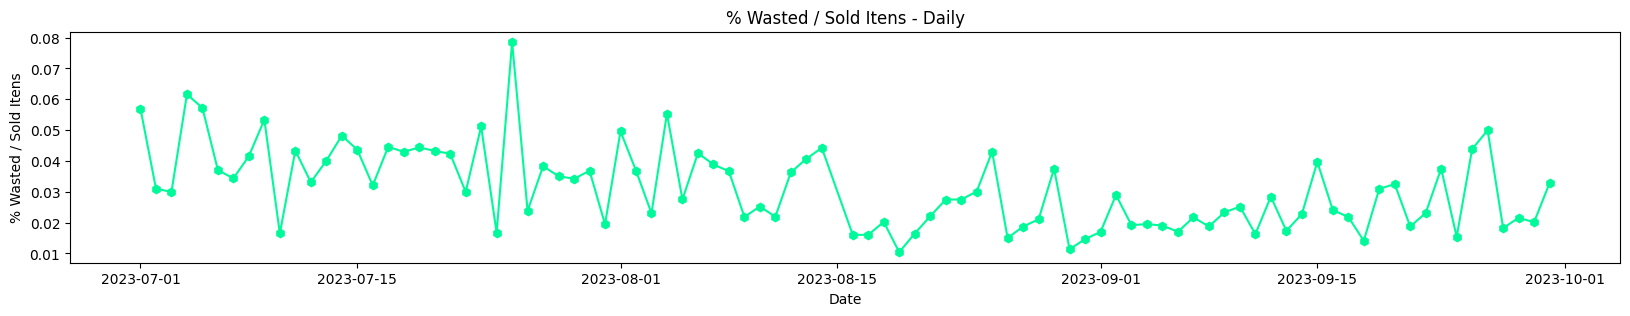

In [38]:
#### Wasted / Sold (%) Itens - Daily
df_wasted_daily = df1[['Time', '# of sold SKU items', 'Waste, # of items']].copy()
df_wasted_daily = df_wasted_daily.groupby('Time').sum().reset_index()
df_wasted_daily["waste_vs_sold_rate"] = df_wasted_daily["Waste, # of items"]  / df_wasted_daily["# of sold SKU items"] 

plt.figure(figsize=(20,3))
plt.plot(df_wasted_daily ["Time"], df_wasted_daily ["waste_vs_sold_rate"], marker = "h", color = "mediumspringgreen")
plt.xlabel('Date')  
plt.ylabel('% Wasted / Sold Itens')  
plt.title("% Wasted / Sold Itens - Daily") 

<Axes: >

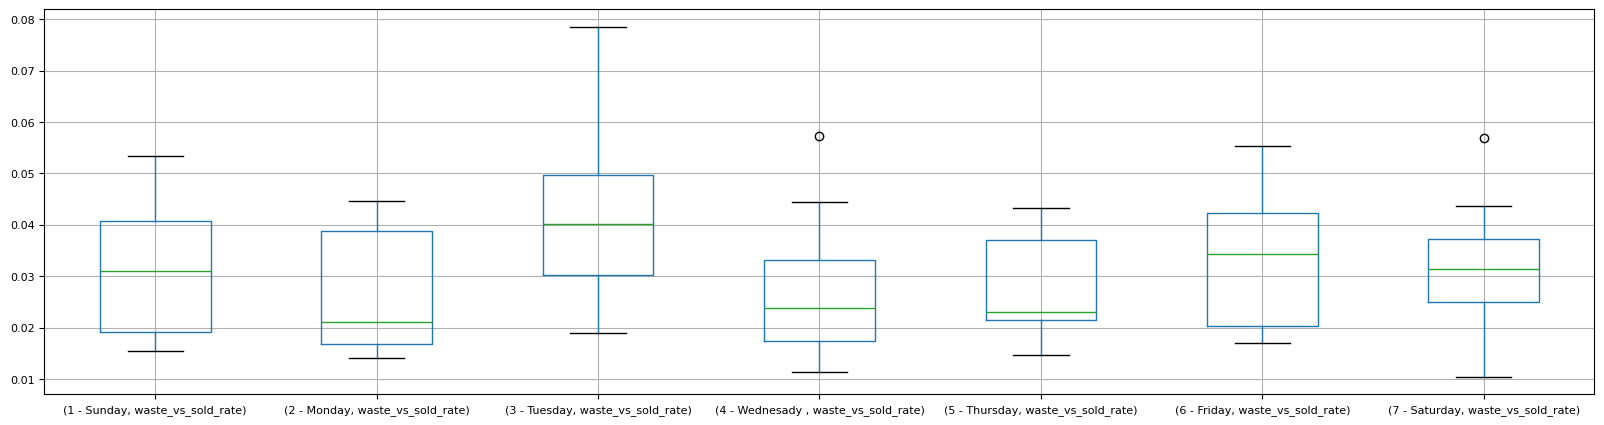

In [130]:
weekref = {0:'2 - Monday', 1:'3 - Tuesday', 2:'4 - Wednesady ', 3:'5 - Thursday', 4:'6 - Friday', 5:'7 - Saturday', 6:'1 - Sunday'}
df_wasted_daily['Week Day'] = df_wasted_daily["Time"].apply(lambda x: weekref[x.weekday()])
df_wasted_daily_gruped = df_wasted_daily[['Week Day', 'waste_vs_sold_rate']].groupby('Week Day')
df_wasted_daily_gruped.boxplot(subplots=False, figsize=(20,5), fontsize=8)  

* We've operated a lower "% wasted / sold" rate since mid August.
* Seems like "Tuesday" is when we tend to have a higher "% wasted / sold" rate. We could experiment operating with a lower stock for a few weeks.

##### 6.2) Revenue, Cost & Discount

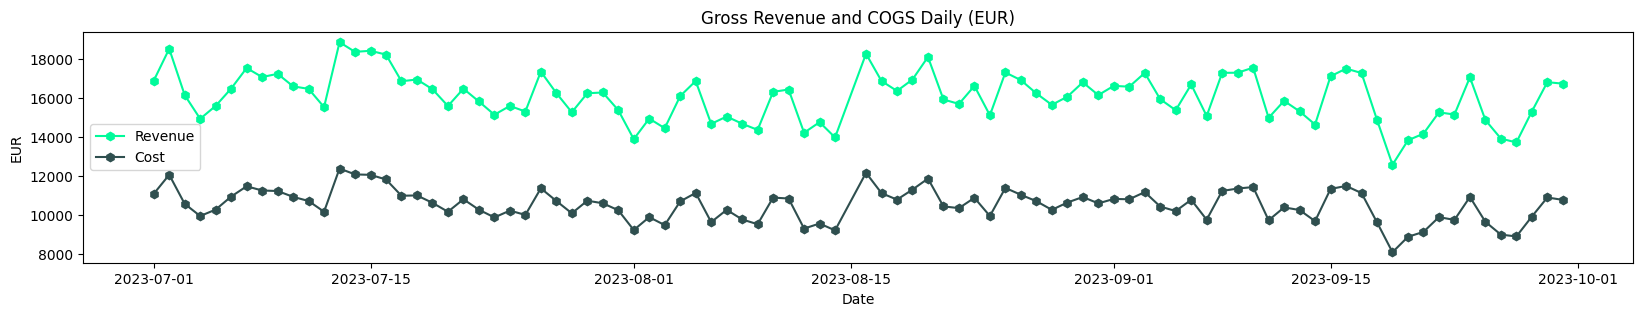

In [41]:
#### Gross Revenue & Cost Daily
df_revenue_daily = df1[["Time","Price before Discount (includ. VAT) (EUR)","Discount Value (EUR)","Item COGS (net VAT) (EUR)"]].copy().rename(columns={"Price before Discount (includ. VAT) (EUR)": "Gross Revenue",
                                                                                                                                                   "Discount Value (EUR)": "Discount",
                                                                                                                                                   "Item COGS (net VAT) (EUR)": "Cost"})
df_revenue_daily = df_revenue_daily.groupby('Time').sum().reset_index()
df_revenue_daily

plt.figure(figsize=(20,3))
plt.plot(df_revenue_daily ["Time"], df_revenue_daily ["Gross Revenue"], marker = "h", color = "mediumspringgreen")
plt.plot(df_revenue_daily ["Time"], df_revenue_daily ["Cost"], marker = "h", color = "darkslategrey")
# plt.plot(df_revenue_daily ["Time"], df_revenue_daily ["Discount"], marker = "*", color = "black")
plt.ylabel('EUR')  
plt.xlabel('Date')  
plt.title("Gross Revenue and COGS Daily (EUR)") 
plt.legend(["Revenue","Cost"])

Text(0.5, 1.0, 'Discount - Daily (EUR)')

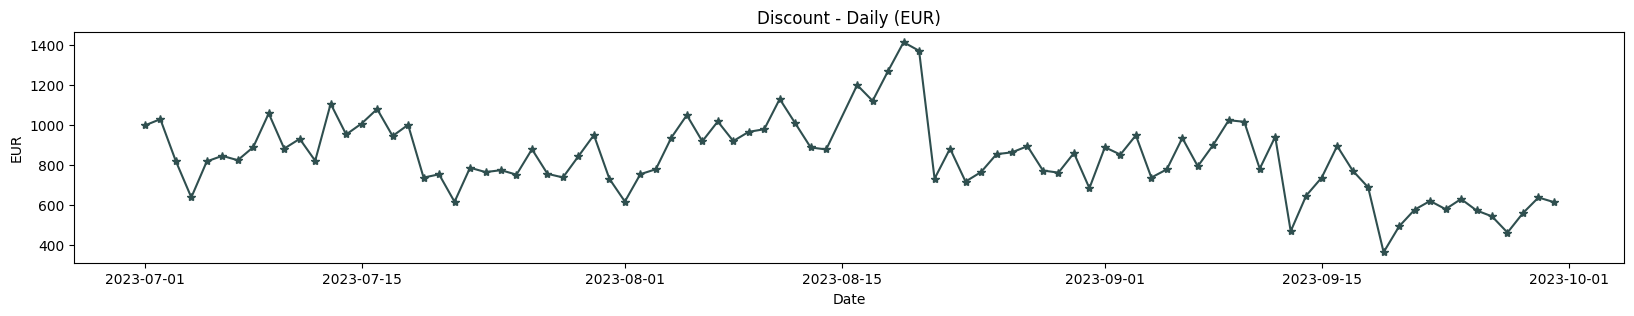

In [42]:
# Discount Daily
plt.figure(figsize=(20,3))

plt.plot(df_revenue_daily ["Time"], df_revenue_daily ["Discount"], marker = "*", color = "darkslategrey")
plt.ylabel('EUR')  
plt.xlabel('Date')  
plt.title("Discount - Daily (EUR)") 

<Axes: >

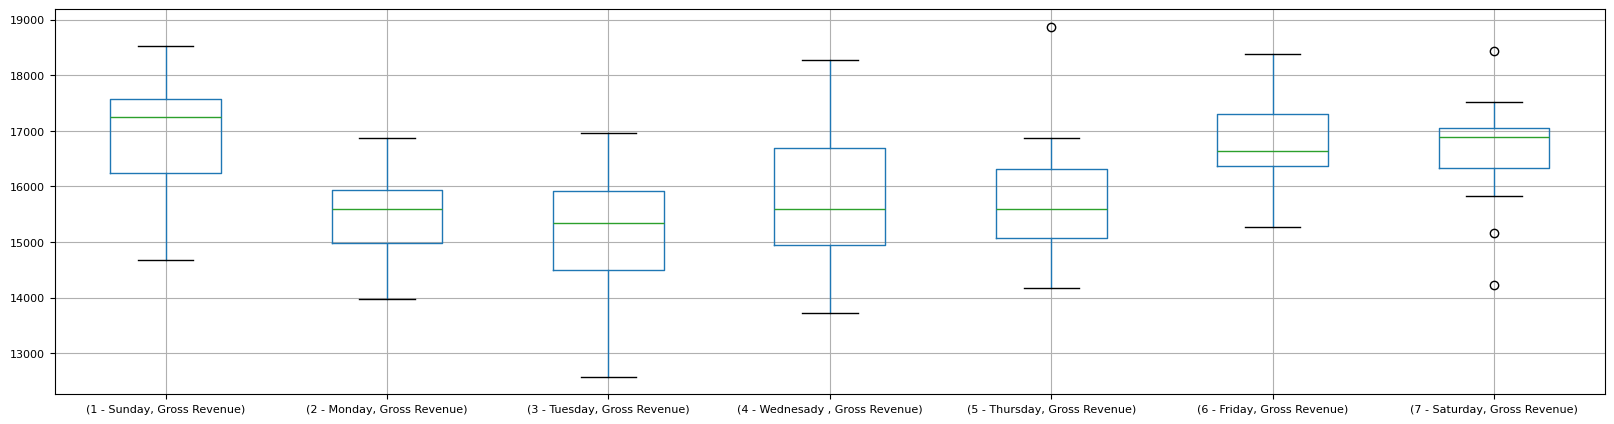

In [134]:
weekref = {0:'2 - Monday', 1:'3 - Tuesday', 2:'4 - Wednesady ', 3:'5 - Thursday', 4:'6 - Friday', 5:'7 - Saturday', 6:'1 - Sunday'}
df_revenue_daily['Week Day'] = df_revenue_daily["Time"].apply(lambda x: weekref[x.weekday()])
df_revenue_daily_grouped = df_revenue_daily[['Week Day', 'Gross Revenue']].groupby('Week Day')
df_revenue_daily_grouped.boxplot(subplots=False, figsize=(20,5), fontsize=8)  

<Axes: >

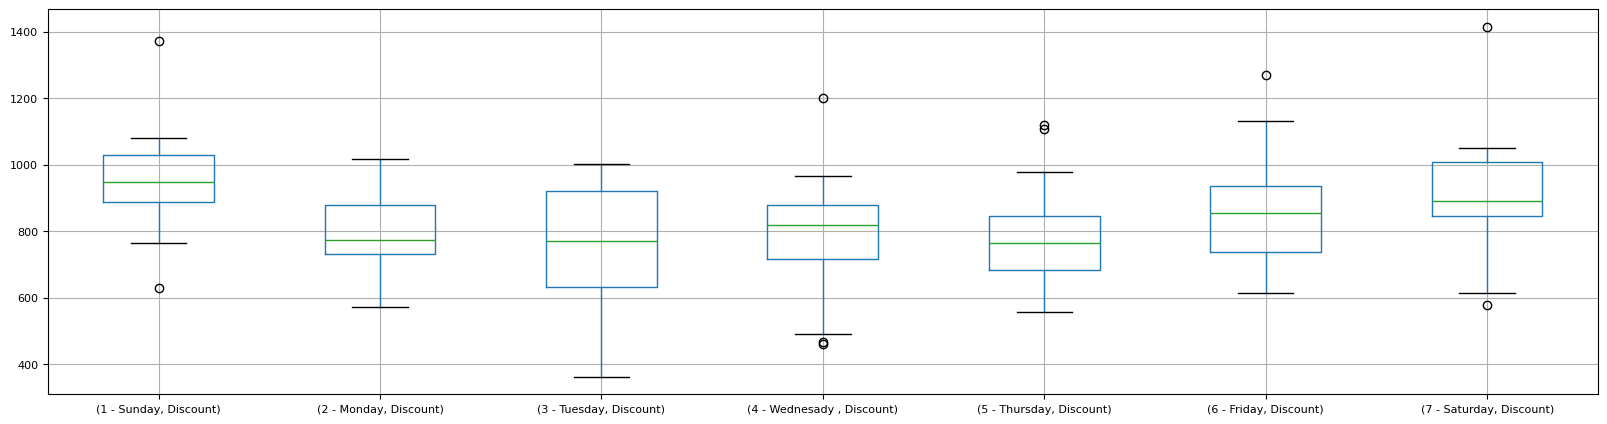

In [137]:
weekref = {0:'2 - Monday', 1:'3 - Tuesday', 2:'4 - Wednesady ', 3:'5 - Thursday', 4:'6 - Friday', 5:'7 - Saturday', 6:'1 - Sunday'}
df_revenue_daily['Week Day'] = df_revenue_daily["Time"].apply(lambda x: weekref[x.weekday()])
df_revenue_daily_grouped = df_revenue_daily[['Week Day', 'Discount']].groupby('Week Day')
df_revenue_daily_grouped.boxplot(subplots=False, figsize=(20,5), fontsize=8)  

* Our week days of strongest sales (gross revenue) are from Friday to Sunday

##### 6.3) % Discount and % Net Margin

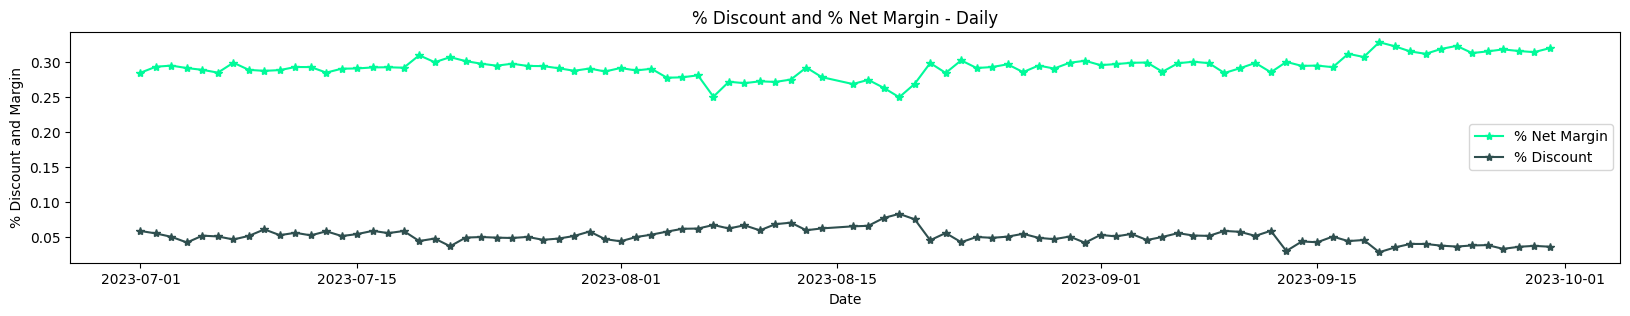

In [43]:
# % Discount and % Margin

df_revenue_daily["Net Revenue"] = df_revenue_daily["Gross Revenue"]  - df_revenue_daily["Discount"]  - df_revenue_daily["Cost"]
df_revenue_daily["perc_margin"] = df_revenue_daily["Net Revenue"] / df_revenue_daily["Gross Revenue"]
df_revenue_daily["perc_discount"] = df_revenue_daily["Discount"] / df_revenue_daily["Gross Revenue"]

plt.figure(figsize=(20,3))
plt.plot(df_revenue_daily ["Time"], df_revenue_daily ["perc_margin"], marker = "*", color = "mediumspringgreen")
plt.plot(df_revenue_daily ["Time"], df_revenue_daily ["perc_discount"], marker = "*", color = "darkslategrey")
plt.ylabel('% Discount and Margin')  
plt.xlabel('Date')  
plt.title("% Discount and % Net Margin - Daily") 
plt.legend(["% Net Margin","% Discount"])

Text(0.5, 0, '% Discount')

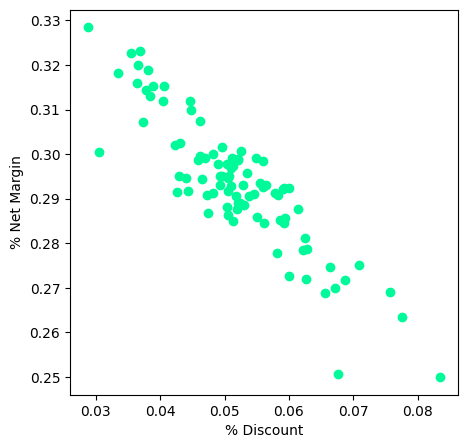

In [46]:
# scatter % discount and % net margin
plt.figure(figsize=(5,5))
plt.scatter(df_revenue_daily["perc_discount"], df_revenue_daily ["perc_margin"], c = "mediumspringgreen")
plt.ylabel('% Net Margin')  
plt.xlabel('% Discount')

* We work with ~29% of net margin, and ~ 5.5% discount rate on most days.
* There were days we reached ~32% of net margin, operating ~ 4.0% discount rate.
* On higher discount days we reached a net margin of less than 27% by giving over 7.0% discounts.

<Axes: >

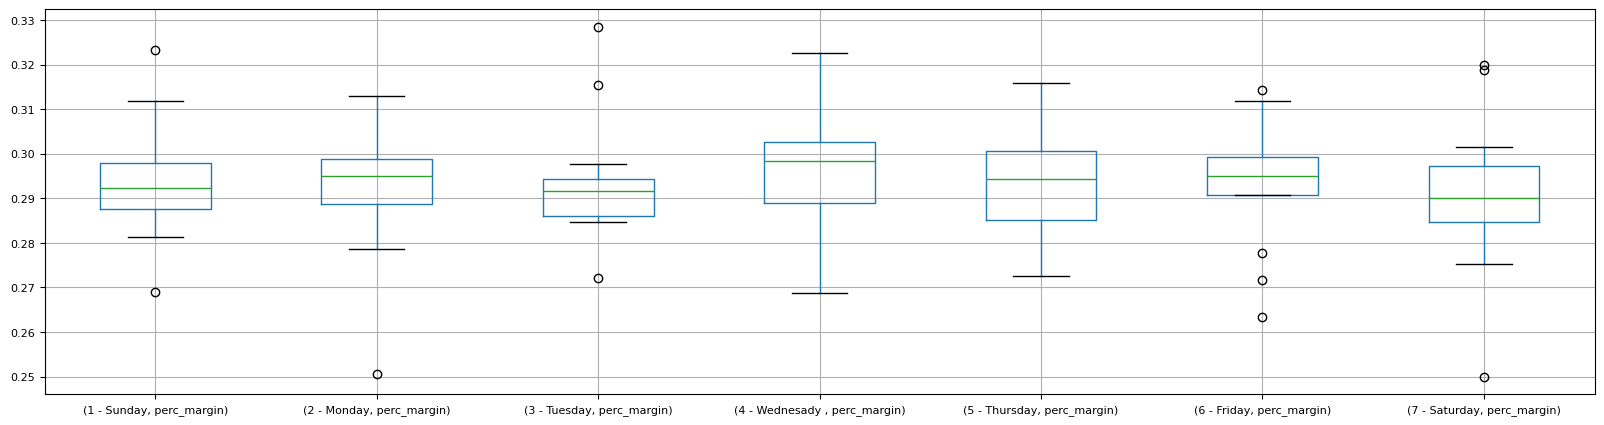

In [139]:
df_revenue_daily_grouped = df_revenue_daily[['Week Day', 'perc_margin']].groupby('Week Day')
df_revenue_daily_grouped.boxplot(subplots=False, figsize=(20,5), fontsize=8)  

<Axes: >

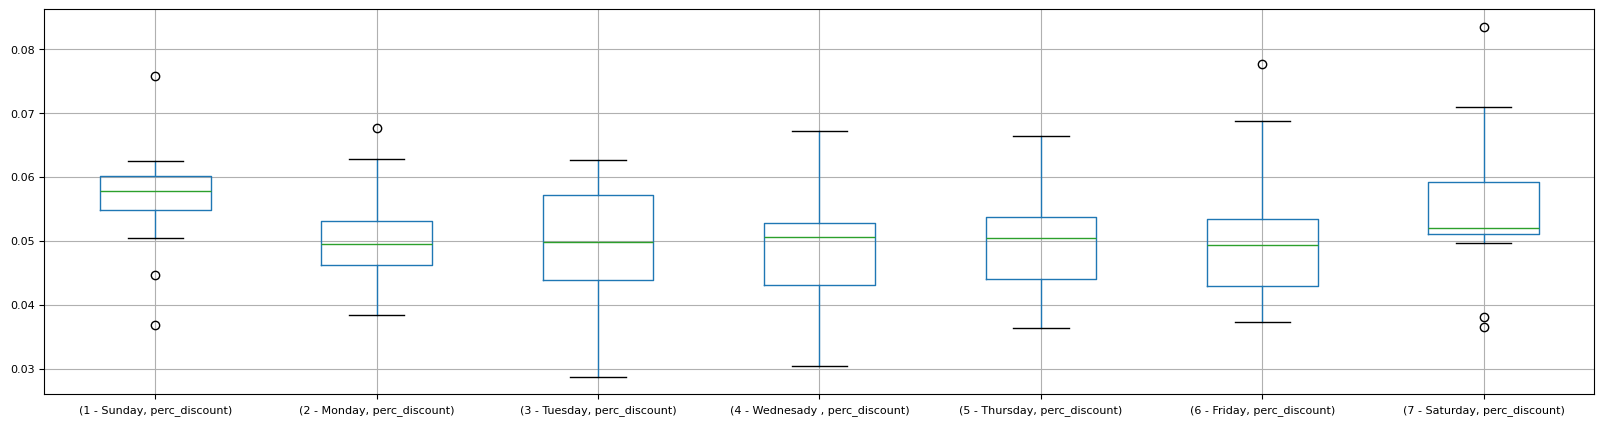

In [140]:
df_revenue_daily_grouped = df_revenue_daily[['Week Day', 'perc_discount']].groupby('Week Day')
df_revenue_daily_grouped.boxplot(subplots=False, figsize=(20,5), fontsize=8)  

* No considerable difference in the % net margin per week day
* Our most aggressive promotions (discounts) are on the weekend.
* Friday was also one of our top 3 sales days. We see now it's more organic.